In [1]:
# General imports
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import optuna
import uuid

# Sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random

# Keras imports
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Tensorflow Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, BatchNormalization, Attention
from tensorflow.keras.optimizers import Adam

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import neural_network_functions as neural_net_fun


In [2]:
# Check if TensorFlow can find the GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("TensorFlow found the following GPU(s):")
    for device in physical_devices:
        print(device)
else:
    print("No GPU found. TensorFlow is running on the CPU.")

No GPU found. TensorFlow is running on the CPU.


## Functions

### Pre-process data

In [3]:
# Load and clean the dataset
def load_and_clean_dataset(dataset_path):
    SEQUENCES = pd.read_csv(dataset_path)

    if 'Unnamed: 0' in SEQUENCES.columns:
        SEQUENCES.drop(columns=['Unnamed: 0'], inplace=True)
    return SEQUENCES

# Filter emotions based on a query
def filter_emotions(SEQUENCES, emotions_query):
    return SEQUENCES.query(emotions_query)

# Encode labels into numerical values
def encode_labels(SEQUENCES_ENCODED):
    encoder = LabelEncoder()
    SEQUENCES_ENCODED['label_numerical'] = encoder.fit_transform(SEQUENCES_ENCODED['label'])
    label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    print("Label Mapping:", label_mapping)
    return SEQUENCES_ENCODED, label_mapping

# Select features
def select_features(SEQUENCES_ENCODED):
    features = SEQUENCES_ENCODED.columns.to_list()[4:25]
    print(f"Features being used: {features}")
    n_features = len(features)
    len_sample_max = SEQUENCES_ENCODED.sample_id.value_counts().max()
    return features, n_features, len_sample_max

# Pad sequences
def pad_sequences(SEQUENCES_ENCODED, features, len_sample_max):
    grouped_data = []
    for sample_id, group in SEQUENCES_ENCODED.groupby('sample_id'):
        sequence_features = group[features]
        if len(sequence_features) < len_sample_max:
            N_rows = len_sample_max - len(sequence_features)
            pad = pd.DataFrame(np.zeros((N_rows, len(features))), columns=sequence_features.columns)
            sequence_features_pad = pd.concat([pad, sequence_features], ignore_index=True)
        else:
            sequence_features_pad = sequence_features
        label = SEQUENCES_ENCODED[SEQUENCES_ENCODED.sample_id == sample_id].iloc[0].label_numerical
        grouped_data.append((sequence_features_pad, label))

    X = np.array([item[0] for item in grouped_data])
    Y = np.array([item[1] for item in grouped_data])
    return X, Y

# Normalize data (using external function)
def normalize_data(X_balanced):
    return neural_net_fun.normalize_data(X_balanced)

# Split data into train, validation, and test sets
def split_data(X, Y, train_size=0.7, val_size=0.15, test_size=0.15):
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=42, shuffle=True)
    val_relative_size = val_size / (train_size + val_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=val_relative_size, stratify=Y_train_val, random_state=42, shuffle=True)

    Y_train = Y_train.reshape(-1, 1)
    Y_val = Y_val.reshape(-1, 1)
    Y_test = Y_test.reshape(-1, 1)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Perform augmentation based on groups of sample_id
def perform_augmentation(SEQUENCES_ENCODED, features, emotions_augmentation_factors):
    augmented_data = []
    for sample_id, group in SEQUENCES_ENCODED.groupby('sample_id'):
        emotion = group['label'].iloc[0]
        label_numerical = group['label_numerical'].iloc[0]
        sequence_features = group[features]

        # Add the original group
        augmented_data.append((sample_id, sequence_features.values, label_numerical))

        # Augment only if the emotion is in the specified list
        if emotion in list(emotions_augmentation_factors.keys()):
            augmentation_factor = emotions_augmentation_factors.get(emotion, 1.0)
            augment_general_chance = augmentation_factor - 1
            augment_current_series_chance = random.random()

            if augment_current_series_chance <= augment_general_chance:
                # Augmentation technique 1: Add Gaussian noise
                noise = np.random.normal(0, 0.01, size=sequence_features.shape)
                augmented_group = sequence_features + noise

                # Create a new sample_id for the augmented group
                new_sample_id = f"{sample_id}_aug_{uuid.uuid4().hex[:8]}"

                # Append the augmented group
                augmented_data.append((new_sample_id, augmented_group, label_numerical))
    
        # Inicializar o DataFrame vazio com as colunas corretas
    augmented_df = pd.DataFrame(columns=['sample_id'] + features + ['label_numerical'])

    # Iterar sobre os dados aumentados
    for sample_id, features_series, label_numerical in augmented_data:
        # Criar um DataFrame temporário para cada item
        temp_df = pd.DataFrame(features_series, columns=features)
        temp_df['sample_id'] = sample_id  # Adicionar o sample_id a todas as linhas
        temp_df['label_numerical'] = label_numerical  # Adicionar o label a todas as linhas

        # Concatenar o DataFrame temporário ao final
        augmented_df = pd.concat([augmented_df, temp_df], ignore_index=True)

    return augmented_df

# Main preprocessing function
def preprocess_data_current_dataset(dataset_path, emotions, emotions_augmentation_factors=None, train_size=0.7, val_size=0.15, test_size=0.15):
    SEQUENCES = load_and_clean_dataset(dataset_path)
    SEQUENCES = filter_emotions(SEQUENCES, emotions)

    SEQUENCES_ENCODED, label_mapping = encode_labels(SEQUENCES)
    features, n_features, len_sample_max = select_features(SEQUENCES_ENCODED)
    timesteps = len_sample_max
    n_classes = len(label_mapping)

    # Perform augmentation
    if emotions_augmentation_factors:
        SEQUENCES_ENCODED_BEFORE = SEQUENCES_ENCODED.copy()  # Save original for comparison
        SEQUENCES_ENCODED = perform_augmentation(SEQUENCES_ENCODED, features, emotions_augmentation_factors)

    # Padding happens after augmentation
    X, Y = pad_sequences(SEQUENCES_ENCODED, features, len_sample_max)
    
    X_complete = normalize_data(X)

    X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X_complete, Y, train_size, val_size, test_size)

    return {
        'label_mapping': label_mapping,
        'timesteps': timesteps,
        'n_classes': n_classes,
        'n_features': n_features,
        'X_complete': X_complete,
        'Y_complete': Y,
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'Y_train': Y_train,
        'Y_val': Y_val,
        'Y_test': Y_test,
        'SEQUENCES_BEFORE': SEQUENCES_ENCODED_BEFORE,  # Data before augmentation
        'SEQUENCES_AFTER': SEQUENCES_ENCODED           # Data after augmentation
    }


In [4]:
def checking_data(label_mapping, timesteps, n_classes, n_features, X_complete, Y_complete, X_train, X_val, X_test, Y_train, Y_val, Y_test):
    print("===== Data Information =====")
    print(f"Timesteps: {timesteps}")
    print(f"Number of classes: {n_classes}")
    print(f"Number of features: {n_features}")
    
    print("\n===== Label Mapping =====")
    for label, numerical_value in label_mapping.items():
        print(f"'{label}' -> {numerical_value}")

    print("\n===== Data Summary =====")
    print(f"Shape of X: {X_complete.shape}")
    print(f"Shape of Y: {Y_complete.shape}")
    print("Sample count per class:")
    for numerical_value, count in enumerate(np.bincount(Y_complete)):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")
    
    print("\n===== Training Set =====")
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of Y_train: {Y_train.shape}")

    train_counts = np.bincount(Y_train.flatten())
    for numerical_value, count in enumerate(train_counts):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")

    print("\n===== Validation Set =====")
    print(f"Shape of X_val: {X_val.shape}")
    print(f"Shape of Y_val: {Y_val.shape}")

    train_counts = np.bincount(Y_val.flatten())
    for numerical_value, count in enumerate(train_counts):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")
    
    print("\n===== Test Set =====")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of Y_test: {Y_test.shape}")

    test_counts = np.bincount(Y_test.flatten())
    for numerical_value, count in enumerate(test_counts):
        label = list(label_mapping.keys())[list(label_mapping.values()).index(numerical_value)]
        print(f"Class '{label}' (Value {numerical_value}): {count} samples")

### Model functions

In [5]:
def define_model(timesteps, num_features, num_classes, lstm_units, dropout_lstm, learning_rate):
    model = Sequential()

    # Usar a camada Input corretamente
    model.add(Input(shape=(timesteps, num_features)))

    # Adição de camada Bidirecional LSTM
    model.add(Bidirectional(LSTM(units=lstm_units, return_sequences=True)))
    model.add(Dropout(dropout_lstm))

    #Adição de camada de Regularização (Batch Normalization)
    model.add(BatchNormalization())

    # LSTM layer
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_lstm))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [6]:
def objective(trial, timesteps, n_classes, n_features, X_balanced_normalized, Y_balanced, batch_size):
    lstm_units = trial.suggest_int('lstm_units', 20, 150)
    dropout_lstm = trial.suggest_float('dropout_lstm', 0.2, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5)

    # Inicializa KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Armazena as pontuações
    scores = []

    for train_index, val_index in kf.split(X_balanced_normalized):
        X_train_fold, X_val = X_balanced_normalized[train_index], X_balanced_normalized[val_index]
        y_train_fold, Y_val = Y_balanced[train_index], Y_balanced[val_index]

        # Cria o modelo
        model = define_model(timesteps, n_features, n_classes, lstm_units, dropout_lstm, learning_rate)
        
        # Callbacks de early stopping e redução da taxa de aprendizado
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=int(10/2), min_lr=1e-6)

        # Converter Y_train e Y_val para one-hot encoding
        y_train_fold = to_categorical(y_train_fold, n_classes)
        Y_val = to_categorical(Y_val, n_classes)

        # Treina o modelo
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=batch_size, verbose=0, validation_data=(X_val, Y_val), callbacks=[early_stopping, lr_scheduler])
        
        # Avalia o modelo
        y_pred = model.predict(X_val)
        y_pred = np.round(y_pred)
        
        # Calcula a precisão para esta fold
        accuracy = accuracy_score(Y_val, y_pred)
        scores.append(accuracy)

        # Limpa a memória e coleta garbage
        del model, X_train_fold, X_val, y_train_fold, Y_val, y_pred
        gc.collect()

    # Calcula a pontuação média
    avg_score = np.mean(scores)
    
    return avg_score

In [7]:
def training_process(timesteps, n_classes, n_features,  X_train, X_val, Y_train, Y_val, model_parameters, batch_size, epochs):
    # Create a study and optimize
    
    model = define_model(timesteps, n_features, n_classes, model_parameters['lstm_units'], model_parameters['dropout_lstm'], model_parameters['learning_rate'])
    patience = 12

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Converter Y_train e Y_val para one-hot encoding
    Y_train = to_categorical(Y_train, n_classes)
    Y_val = to_categorical(Y_val, n_classes)

    # Train the model with early stopping
    history = model.fit(
        X_train, Y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, Y_val),  
        callbacks=[early_stopping]
    )

    return history, model

In [8]:
def evaluate_model_performance(model, X_train, y_train, X_test, y_test, class_labels):
    # Número de classes
    num_classes = len(class_labels)
    
    # Convert y_train e y_test para codificação one-hot
    y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
    y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
    
    # Obter probabilidades preditas
    y_train_pred_proba = model.predict(X_train)
    y_test_pred_proba = model.predict(X_test)
    
    # Obter classes preditas (classe com a maior probabilidade)
    y_train_pred = np.argmax(y_train_pred_proba, axis=1)
    y_test_pred = np.argmax(y_test_pred_proba, axis=1)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Imprimir métricas
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    
    # Plotar matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular ROC AUC para cada classe
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_test_pred_proba[:, i])
        roc_auc[i] = roc_auc_score(y_test_one_hot[:, i], y_test_pred_proba[:, i])
    
    # Plotar curvas ROC para cada classe
    plt.figure()
    colors = plt.cm.get_cmap('tab10', num_classes)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'ROC curve of class {class_labels[i]} (AUC = {roc_auc[i]:0.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy, precision, recall, f1, conf_matrix

In [9]:
def plot_learning_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history.history['accuracy']), 5))  # Set x-axis ticks every 5 epochs
    plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
    plt.title('Model Accuracy')

    # Plot training & validation loss values (linear scale)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'][:60], label='Training Loss (Linear)', color='blue')
    plt.plot(history.history['val_loss'][:60], label='Validation Loss (Linear)', color='orange')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0,)  # Automatically scale the y-axis starting at 0
    plt.xticks(range(0, len(history.history['loss']), 5))  # Set x-axis ticks every 5 epochs
    plt.legend(loc='upper left')
    plt.title('Model Loss')

    # Add log-scale loss in the same plot
    plt.twinx()  # Create a secondary y-axis sharing the same x-axis
    plt.plot(history.history['loss'][:60], linestyle='--', color='blue', alpha=0.7, label='Training Loss (Log)')
    plt.plot(history.history['val_loss'][:60], linestyle='--', color='orange', alpha=0.7, label='Validation Loss (Log)')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.ylabel('Loss (Log Scale)')
    plt.legend(loc='upper right')

    #plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()


In [10]:
def show_data_before_augment(data):
    # Agregar por `sample_id` e manter apenas a primeira ocorrência do `label` por ID
    aggregated_data = data.groupby('sample_id').first()

    # Contar a quantidade de cada emoção (label)
    emotion_counts = aggregated_data['label'].value_counts()

    # Quantidade total de amostras únicas por sample_id
    total_count = len(aggregated_data)

    print("Quantidade de cada emoção ANTES DO AUGMENT (agregado por sample_id):")
    print(emotion_counts)
    print("\nQuantidade total (sample_id únicos):", total_count)


## Getting data

In [11]:
SEQUENCES_NAME_FILE = os.path.join("result_sequences", "DATASET_SEQUENCES_4.CSV")

In [12]:
# All words - aleatorio 'random' or 'others' || 'interview'
emotions = ['aleatorio', 'interview']

# Building the query with the emotions
emotions_query = " | ".join([f"label == '{emotion}'" for emotion in emotions])

emotions_augmentation_factors = {'anger': 1.4, 'contempt': 1.4, 'sadness': 1.4, 'fear': 1.4}

data_info = preprocess_data_current_dataset(
        SEQUENCES_NAME_FILE, 
        emotions = emotions_query,
        emotions_augmentation_factors=emotions_augmentation_factors
    )

# Agora você pode acessar cada item no dicionário 'data_info' usando as chaves
label_mapping = data_info['label_mapping']
timesteps = data_info['timesteps']
n_classes = data_info['n_classes']
n_features = data_info['n_features']

X_complete = data_info['X_complete']
Y_complete = data_info['Y_complete']

X_train = data_info['X_train']
X_val = data_info['X_val']
X_test = data_info['X_test']

Y_train = data_info['Y_train']
Y_val = data_info['Y_val']
Y_test = data_info['Y_test']

SEQUENCES_BEFORE = data_info['SEQUENCES_BEFORE']
SEQUENCES_AFTER = data_info['SEQUENCES_AFTER']


Label Mapping: {'aleatorio': 0, 'interview': 1}
Features being used: ['m3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'e1', 'e2', 'e3', 'b1', 'b2', 'b3']


In [13]:
show_data_before_augment(SEQUENCES_BEFORE)

Quantidade de cada emoção ANTES DO AUGMENT (agregado por sample_id):
label
aleatorio    55
interview    55
Name: count, dtype: int64

Quantidade total (sample_id únicos): 110


In [14]:
checking_data(label_mapping, timesteps, n_classes, n_features, X_complete, Y_complete, X_train, X_val, X_test, Y_train, Y_val, Y_test)

===== Data Information =====
Timesteps: 37
Number of classes: 2
Number of features: 21

===== Label Mapping =====
'aleatorio' -> 0
'interview' -> 1

===== Data Summary =====
Shape of X: (110, 37, 21)
Shape of Y: (110,)
Sample count per class:
Class 'aleatorio' (Value 0): 55 samples
Class 'interview' (Value 1): 55 samples

===== Training Set =====
Shape of X_train: (76, 37, 21)
Shape of Y_train: (76, 1)
Class 'aleatorio' (Value 0): 38 samples
Class 'interview' (Value 1): 38 samples

===== Validation Set =====
Shape of X_val: (17, 37, 21)
Shape of Y_val: (17, 1)
Class 'aleatorio' (Value 0): 8 samples
Class 'interview' (Value 1): 9 samples

===== Test Set =====
Shape of X_test: (17, 37, 21)
Shape of Y_test: (17, 1)
Class 'aleatorio' (Value 0): 9 samples
Class 'interview' (Value 1): 8 samples


## Tunning

In [ ]:
#batch_size = 16

# Getting the best hyperparameters
#study = optuna.create_study(direction='maximize')
#study.optimize(lambda trial: objective(trial, timesteps, n_classes, n_features, X_complete, Y_complete, batch_size=batch_size), n_trials=20)
#print("Best params found:", study.best_params)

## Training

In [18]:
#second best: {'lstm_units': 54, 'dropout_lstm': 0.2636499716580319, 'learning_rate': 0.0013382539665472643}
params = {'lstm_units': 42, 'dropout_lstm': 0.29918084076709983, 'learning_rate': 0.005746246326776903} #study.best_params
batch_size = 16

history, model = training_process(timesteps, n_classes, n_features, X_train, X_val, Y_train, Y_val, params, batch_size=batch_size, epochs=40)

Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.4390 - loss: 0.8365 - val_accuracy: 0.5294 - val_loss: 0.6791
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5784 - loss: 0.6832 - val_accuracy: 0.4706 - val_loss: 0.7010
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6663 - loss: 0.6392 - val_accuracy: 0.4706 - val_loss: 0.7446
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7160 - loss: 0.5839 - val_accuracy: 0.5294 - val_loss: 0.6373
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7534 - loss: 0.4920 - val_accuracy: 0.4706 - val_loss: 0.8913
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6030 - loss: 0.6958 - val_accuracy: 0.4706 - val_loss: 0.6862
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8206 - loss: 0.4818 - val_accuracy: 0.4706 - val_loss: 0.7778
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8041 - loss: 0.4970 - val_accuracy: 0.8235 - val_loss: 0.4618

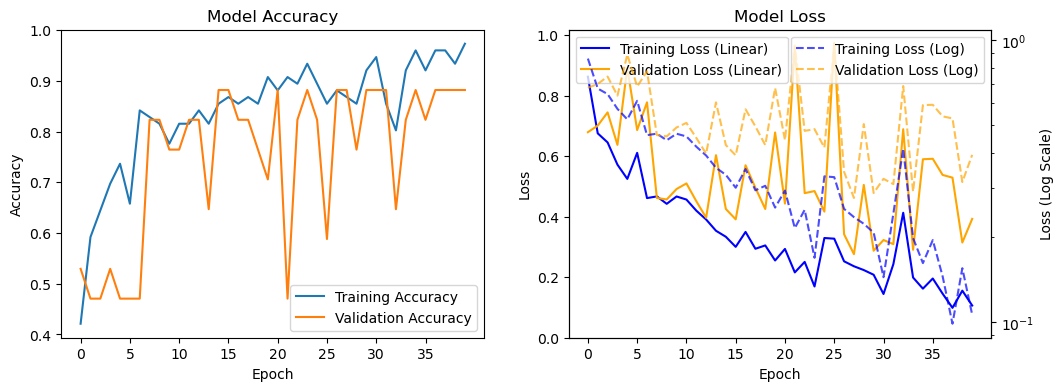

In [19]:
plot_learning_curves(history)

## Evaluating

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1-Score: 0.94


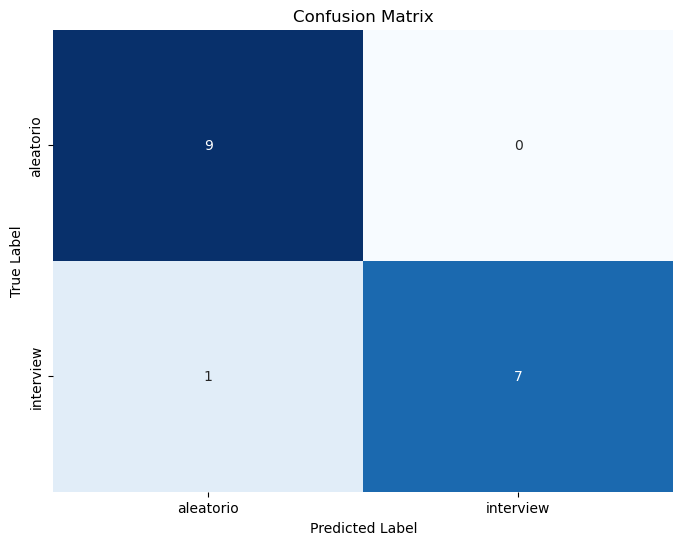

C:\Users\Nilton\AppData\Local\Temp\ipykernel_26168\2919547274.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


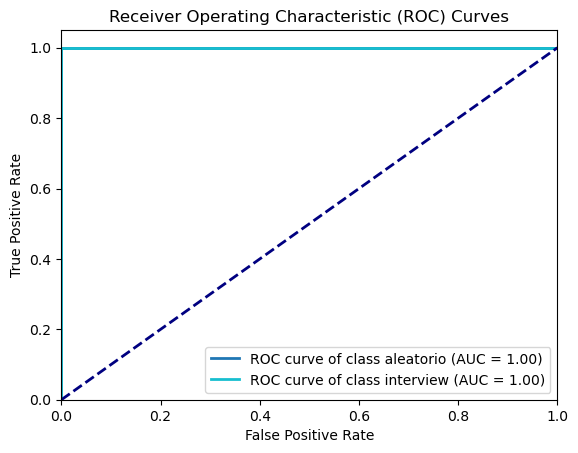

(0.9411764705882353,
 0.9470588235294118,
 0.9411764705882353,
 0.9407636738906088,
 array([[9, 0],
        [1, 7]], dtype=int64))

In [20]:
evaluate_model_performance(model, X_train, Y_train, X_test, Y_test, class_labels=emotions)

In [23]:
# Saving the model
model.save('model_for_' + str(len(emotions)) + "_emotions.keras")